In [58]:
# Imports
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import pickle

from qiskit_optimization.applications import Maxcut
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit import qasm3

In [2]:
# Load the graphs
G5 = pickle.load(open("graph5.pkl", "rb"))
G10 = pickle.load(open("graph10.pkl", "rb"))
G15 = pickle.load(open("graph15.pkl", "rb"))

In [9]:
# Create maxcut problems
maxcut5 = Maxcut(G5)
maxcut10 = Maxcut(G10)
maxcut15 = Maxcut(G15)

In [10]:
qubo5 = maxcut5.to_quadratic_program()
qubo10 = maxcut10.to_quadratic_program()
qubo15 = maxcut15.to_quadratic_program()

In [14]:
# Create the operators
op5, offset5 = qubo5.to_ising()
op10, offset10 = qubo10.to_ising()
op15, offset15 = qubo15.to_ising()

In [47]:
# Define the circuits
# 4 types of circuits: RealAmplitudes, EfficientSU2 with RZs, Just RZs, Naive approach, layer of RZs with full entanglement

operators = [op5, op10, op15]
l_circs = []

for i in range(len(operators)):
    operator = operators[i]
    l_circs.append([])
    num_qubits = operator.num_qubits
    # RealAmplitudes
    ra = RealAmplitudes(num_qubits, reps=1,flatten=True)
    l_circs[i].append(ra)
    # EfficientSU2 with RZs
    esu2 = EfficientSU2(num_qubits, reps=1, flatten=True)
    l_circs[i].append(esu2)
    # Just RZs
    rzs = QuantumCircuit(num_qubits)
    p_vec = ParameterVector('θ', num_qubits)
    for j in range(num_qubits):
        rzs.ry(p_vec[j], j)
    l_circs[i].append(rzs)
    # EfficientSU2 with 1 RZ
    full_naive = EfficientSU2(num_qubits, reps=1, flatten=True, entanglement='full', skip_final_rotation_layer=True, su2_gates=['ry'])
    l_circs[i].append(full_naive)

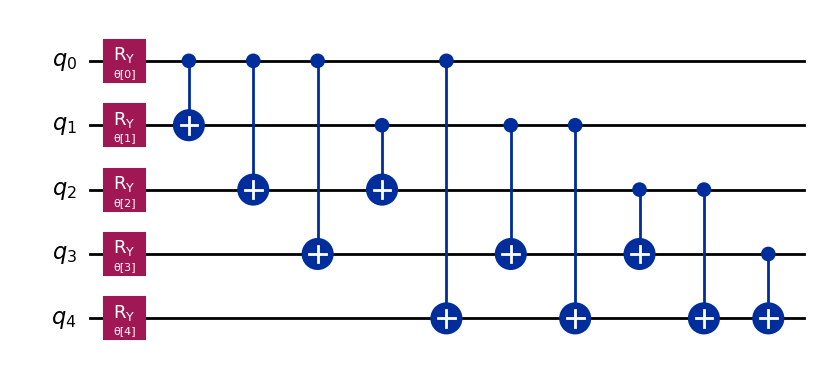

In [56]:
l_circs[0][3].draw('mpl',fold=-1)

In [59]:
# Save the circuits as qasm3
directory = 'circuits/'
#check and create directory
import os
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the circuits
sizes = ['5', '10', '15']
circ_names = ['RA', 'ESU2', 'RZ', 'FN']
for i in range(len(l_circs)):
    size = sizes[i]
    for j in range(len(l_circs[i])):
        circ = l_circs[i][j]
        circ_name = circ_names[j] + size
        with open(directory + circ_name + '.qasm', 'w') as f:
            qasm3.dump(circ, f)


In [62]:
# Save the operators
directory = 'operators/'
#check and create directory
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the operators as list of paulis \n###\n list of coefficients
for i in range(len(operators)):
    operator = operators[i]
    size = sizes[i]
    pauli_list = operator.paulis
    coeffs = operator.coeffs
    with open(directory + 'operator' + size + '.txt', 'w') as f:
        f.write(str(pauli_list) + '\n###\n' + str(coeffs.tolist()))